In [1]:
import os
import time
import math
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import random
from typing import List, Tuple
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
# Path to your DTD dataset (downloaded and extracted)

DATASET_PATH = f"{os.getcwd()}/ambient-cg-images"
DATASET_PATH

'C:\\Projects\\Texture-SuperResolution/ambient-cg-images'

In [3]:
# -----------------------------
# 🔹 Preprocessing Function
# -----------------------------
IMAGE_LIMIT = 100

def load_dtd_dataset(root_dir, scale_factor=2, patch_size=64, test_size=0.2):
    """
    Loads DTD dataset and creates LR-HR pairs as numpy arrays.
    """
    image_files = []
    counter = 0
    for root, _, files in os.walk(root_dir):
        if counter > IMAGE_LIMIT:
            break
        for f in files:
            if counter > IMAGE_LIMIT:
                break
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, f))
                counter += 1
                
    to_tensor = transforms.ToTensor()
    X, Y = [], []

    for img_path in image_files:
        hr_img = Image.open(img_path).convert("RGB")
        width, height = hr_img.size
        patch_size = min(width, height)

        # Ensure patch fits
        if width < patch_size or height < patch_size:
            hr_img = hr_img.resize((patch_size, patch_size), Image.BICUBIC)
        else:
            # Random crop
            left = np.random.randint(0, width - patch_size + 1)
            top = np.random.randint(0, height - patch_size + 1)
            hr_img = hr_img.crop((left, top, left + patch_size, top + patch_size))

        # Create low-res version
        lr_size = (patch_size // scale_factor, patch_size // scale_factor)
        lr_img = hr_img.resize(lr_size, Image.BICUBIC)
        lr_img = lr_img.resize((patch_size, patch_size), Image.BICUBIC)

        # Convert to tensors (C,H,W) and append
        X.append(to_tensor(lr_img).numpy())
        Y.append(to_tensor(hr_img).numpy())

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    # Train/val split
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)

    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = load_dtd_dataset(DATASET_PATH, scale_factor=2, patch_size=192)

C:\Users\neelr\AppData\Roaming\Python\Python313\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (150994944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
class TextureDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)  # convert to torch.Tensor
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [5]:
train_dataset = TextureDataset(X_train, Y_train)
val_dataset = TextureDataset(X_val, Y_val)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

# Test one sample
lr, hr = train_dataset[56]
print("LR shape:", lr.shape, "HR shape:", hr.shape)

Train samples: 80
Val samples: 21
LR shape: torch.Size([3, 192, 192]) HR shape: torch.Size([3, 192, 192])


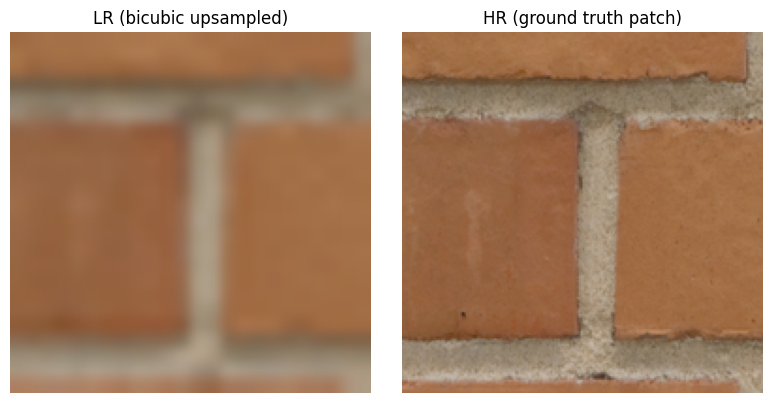

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(np.transpose(lr.numpy(), (1, 2, 0)))
axes[0].set_title("LR (bicubic upsampled)")
axes[0].axis("off")
axes[1].imshow(np.transpose(hr.numpy(), (1, 2, 0)))
axes[1].set_title("HR (ground truth patch)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [7]:
BATCH_SIZE   = 16
NUM_EPOCHS   = 400
LR           = 1e-3
STEP_EVERY   = 15
GAMMA        = 0.5
NUM_WORKERS  = 0
PIN_MEMORY   = False
FSRCNN_SCALE = 2

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [9]:
from model import SRCNN
from model import FSRCNN

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))


def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


model = FSRCNN(FSRCNN_SCALE, num_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([
        {'params': model.first_part.parameters()},
        {'params': model.mid_part.parameters()},
        {'params': model.last_part.parameters(), 'lr': LR * 0.1}
    ], LR)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % BATCH_SIZE)) as t:
        t.set_description('epoch: {}/{}'.format(epoch, NUM_EPOCHS - 1))

        for data in train_loader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    model.eval()
    epoch_psnr = AverageMeter()

    for data in val_loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs).clamp(0.0, 1.0)

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, os.path.join("./", 'best.pth'))

epoch: 0/399:   0%|                                                                             | 0/80 [00:00<?, ?it/s]C:\Users\neelr\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([16, 3, 192, 192])) that is different to the input size (torch.Size([16, 3, 384, 384])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch: 0/399:   0%|                                                                             | 0/80 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (384) must match the size of tensor b (192) at non-singleton dimension 3

In [ ]:
def to_hwc_np(t: torch.Tensor):
    """[C,H,W] float in [0,1] -> HxW(c) numpy for imshow."""
    t = t.detach().cpu().clamp(0,1)
    if t.ndim == 3 and t.shape[0] == 3:
        return np.transpose(t.numpy(), (1, 2, 0))
    return t.squeeze(0).numpy()

def psnr(a: torch.Tensor, b: torch.Tensor, eps=1e-10):
    # a,b: [C,H,W] in [0,1]
    mse = torch.mean((a - b) ** 2).item()
    return 20 * np.log10(1.0 / math.sqrt(mse + eps))

def rgb_to_y(t: torch.Tensor) -> torch.Tensor:
    """[C,H,W] RGB in [0,1] -> [1,H,W] Y (BT.601)."""
    if t.shape[0] == 1:
        return t
    r, g, b = t[0], t[1], t[2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    return y.unsqueeze(0)

def rgb_to_ycbcr(t: torch.Tensor):
    """[C,H,W] RGB in [0,1] -> (Y,Cb,Cr) each [1,H,W], BT.601 with 0.5 offset for Cb/Cr."""
    r, g, b = t[0], t[1], t[2]
    Y  = 0.299  * r + 0.587  * g + 0.114  * b
    Cb = -0.168736 * r - 0.331264 * g + 0.5      * b + 0.5
    Cr =  0.5      * r - 0.418688 * g - 0.081312 * b + 0.5
    return Y.unsqueeze(0), Cb.unsqueeze(0), Cr.unsqueeze(0)

def ycbcr_to_rgb(Y: torch.Tensor, Cb: torch.Tensor, Cr: torch.Tensor):
    """Y,Cb,Cr in [0,1] (Cb/Cr centered at 0.5) -> [3,H,W] RGB in [0,1]."""
    r = Y + 1.402   * (Cr - 0.5)
    g = Y - 0.344136 * (Cb - 0.5) - 0.714136 * (Cr - 0.5)
    b = Y + 1.772   * (Cb - 0.5)
    out = torch.stack([r, g, b], dim=0).clamp(0, 1)
    return out

model.eval()

# ---------- Pick random samples from the validation set ----------
NUM_SAMPLES = 4
rand_idxs = random.sample(range(len(train_dataset)), k=min(NUM_SAMPLES, len(train_dataset)))

for i, idx in enumerate(rand_idxs, 1):
    lr, hr = train_dataset[idx]   # [C,H,W] in [0,1]; LR is bicubic-upsampled to HR size

    # Match model channels
    if model.conv1.in_channels == 1:
        # Y-channel model
        if lr.shape[0] == 3:
            # Keep chroma from LR for colorizing the SR output
            Y_lr, Cb_lr, Cr_lr = rgb_to_ycbcr(lr)
            Y_hr = rgb_to_y(hr)
            lr_in = Y_lr.to(device)                     # [1,H,W]
            with torch.no_grad():
                sr_y = model(lr_in.unsqueeze(0)).squeeze(0).cpu().clamp(0,1)  # [1,H,W]
            # Recolor SR using LR chroma for display
            sr_rgb = ycbcr_to_rgb(sr_y, Cb_lr, Cr_lr)
            # For fair PSNR, compute on Y
            psnr_bic = psnr(Y_lr, Y_hr)
            psnr_sr  = psnr(sr_y, Y_hr)

            # What to show:
            img_lr = lr                    # color bicubic input (for context)
            img_sr = sr_rgb                # colorized SR
            img_hr = hr                    # GT color

            title_mid = f"SRCNN (Y only)  PSNR(Y)={psnr_sr:.2f} dB"
            title_left = f"LR Bicubic  PSNR(Y)={psnr_bic:.2f} dB"
        else:
            # Dataset already single-channel
            lr_in = lr.to(device)
            with torch.no_grad():
                sr = model(lr_in.unsqueeze(0)).squeeze(0).cpu().clamp(0,1)
            psnr_bic = psnr(lr, hr)
            psnr_sr  = psnr(sr, hr)
            img_lr, img_sr, img_hr = lr, sr, hr
            title_mid = f"SRCNN  PSNR={psnr_sr:.2f} dB"
            title_left = f"LR Bicubic  PSNR={psnr_bic:.2f} dB"
    else:
        # RGB model
        lr_in = lr.to(device)
        with torch.no_grad():
            sr = model(lr_in.unsqueeze(0)).squeeze(0).cpu().clamp(0,1)
        # PSNR on Y for fair comparison (common in SR)
        psnr_bic = psnr(rgb_to_y(lr), rgb_to_y(hr))
        psnr_sr  = psnr(rgb_to_y(sr), rgb_to_y(hr))
        img_lr, img_sr, img_hr = lr, sr, hr
        title_mid = f"SRCNN (RGB)  PSNR(Y)={psnr_sr:.2f} dB"
        title_left = f"LR Bicubic  PSNR(Y)={psnr_bic:.2f} dB"

    # ---------- Plot ----------
    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    axes[0].imshow(to_hwc_np(img_lr))
    axes[0].set_title(title_left)
    axes[0].axis("off")

    axes[1].imshow(to_hwc_np(img_sr))
    axes[1].set_title(title_mid)
    axes[1].axis("off")

    axes[2].imshow(to_hwc_np(img_hr))
    axes[2].set_title("HR Ground Truth")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()